In [1]:
# importing libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math

C:\Users\DELL\anaconda3\Lib\site-packages\pandas\core\arrays\masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [2]:
# Importing models
from sklearn.impute import KNNImputer
from sklearn.preprocessing import LabelEncoder, PolynomialFeatures, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.metrics import mean_absolute_error , mean_squared_error , r2_score
from xgboost import XGBRegressor
import optuna

#Ignore warnings
import warnings
warnings.simplefilter("ignore")

# set seed for reproducibility
np.random.seed(0)

In [3]:
# Loading the data
train = pd.read_csv('Train.csv')
test = pd.read_csv('Test.csv')

In [4]:
# looking at the data
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,1998,NaN,Tier 3,Grocery Store,732.3800
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,1987,High,Tier 3,Supermarket Type1,994.7052


In [5]:
train.Item_Type.value_counts()

Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: count, dtype: int64

In [6]:
# check the rows and column
train.shape

(8523, 12)

In [7]:
# Information about the train
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            8523 non-null   object 
 1   Item_Weight                7060 non-null   float64
 2   Item_Fat_Content           8523 non-null   object 
 3   Item_Visibility            8523 non-null   float64
 4   Item_Type                  8523 non-null   object 
 5   Item_MRP                   8523 non-null   float64
 6   Outlet_Identifier          8523 non-null   object 
 7   Outlet_Establishment_Year  8523 non-null   int64  
 8   Outlet_Size                6113 non-null   object 
 9   Outlet_Location_Type       8523 non-null   object 
 10  Outlet_Type                8523 non-null   object 
 11  Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(7)
memory usage: 799.2+ KB


In [8]:
# include='all' to see the descriptive stats about all types of variables
train.describe(include='all')

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
count,8523,7060.000000,8523,8523.000000,8523,8523.000000,8523,8523.000000,6113,8523,8523,8523.000000
unique,1559,NaN,5,NaN,16,NaN,10,NaN,3,3,4,NaN
top,FDW13,NaN,Low Fat,NaN,Fruits and Vegetables,NaN,OUT027,NaN,Medium,Tier 3,Supermarket Type1,NaN
freq,10,NaN,5089,NaN,1232,NaN,935,NaN,2793,3350,5577,NaN
mean,NaN,12.857645,NaN,0.066132,NaN,140.992782,NaN,1997.831867,NaN,NaN,NaN,2181.288914
std,NaN,4.643456,NaN,0.051598,NaN,62.275067,NaN,8.371760,NaN,NaN,NaN,1706.499616
min,NaN,4.555000,NaN,0.000000,NaN,31.290000,NaN,1985.000000,NaN,NaN,NaN,33.290000
25%,NaN,8.773750,NaN,0.026989,NaN,93.826500,NaN,1987.000000,NaN,NaN,NaN,834.247400
50%,NaN,12.600000,NaN,0.053931,NaN,143.012800,NaN,1999.000000,NaN,NaN,NaN,1794.331000
75%,NaN,16.850000,NaN,0.094585,NaN,185.643700,NaN,2004.000000,NaN,NaN,NaN,3101.296400


In [9]:
# null values sum
train.isnull().sum().sort_values(ascending=False)

Outlet_Size                  2410
Item_Weight                  1463
Item_Identifier                 0
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

In [10]:
train.Outlet_Establishment_Year

0       1999
1       2009
2       1999
3       1998
4       1987
        ... 
8518    1987
8519    2002
8520    2004
8521    2009
8522    1997
Name: Outlet_Establishment_Year, Length: 8523, dtype: int64

In [11]:
train['Outlet_Identifier'].value_counts()

Outlet_Identifier
OUT027    935
OUT013    932
OUT049    930
OUT046    930
OUT035    930
OUT045    929
OUT018    928
OUT017    926
OUT010    555
OUT019    528
Name: count, dtype: int64

In [12]:
test.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type
0,FDW58,20.750,Low Fat,0.007565,Snack Foods,107.8622,OUT049,1999,Medium,Tier 1,Supermarket Type1
1,FDW14,8.300,reg,0.038428,Dairy,87.3198,OUT017,2007,NaN,Tier 2,Supermarket Type1
2,NCN55,14.600,Low Fat,0.099575,Others,241.7538,OUT010,1998,NaN,Tier 3,Grocery Store
3,FDQ58,7.315,Low Fat,0.015388,Snack Foods,155.0340,OUT017,2007,NaN,Tier 2,Supermarket Type1
4,FDY38,NaN,Regular,0.118599,Dairy,234.2300,OUT027,1985,Medium,Tier 3,Supermarket Type3


In [13]:
# information about test
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5681 entries, 0 to 5680
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Identifier            5681 non-null   object 
 1   Item_Weight                4705 non-null   float64
 2   Item_Fat_Content           5681 non-null   object 
 3   Item_Visibility            5681 non-null   float64
 4   Item_Type                  5681 non-null   object 
 5   Item_MRP                   5681 non-null   float64
 6   Outlet_Identifier          5681 non-null   object 
 7   Outlet_Establishment_Year  5681 non-null   int64  
 8   Outlet_Size                4075 non-null   object 
 9   Outlet_Location_Type       5681 non-null   object 
 10  Outlet_Type                5681 non-null   object 
dtypes: float64(3), int64(1), object(7)
memory usage: 488.3+ KB


## EDA (Exploratory Data Analysis)

In [14]:
# checking float64 and int64 dtypes columns

numeric_cols = train.select_dtypes(include=['float64','int64']).columns.tolist()
numeric_cols

['Item_Weight',
 'Item_Visibility',
 'Item_MRP',
 'Outlet_Establishment_Year',
 'Item_Outlet_Sales']

In [15]:
# Transposed summary statistics of the dataset
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Item_Weight,7060.0,12.857645,4.643456,4.555,8.773750,12.600000,16.850000,21.350000
Item_Visibility,8523.0,0.066132,0.051598,0.000,0.026989,0.053931,0.094585,0.328391
Item_MRP,8523.0,140.992782,62.275067,31.290,93.826500,143.012800,185.643700,266.888400
Outlet_Establishment_Year,8523.0,1997.831867,8.371760,1985.000,1987.000000,1999.000000,2004.000000,2009.000000
Item_Outlet_Sales,8523.0,2181.288914,1706.499616,33.290,834.247400,1794.331000,3101.296400,13086.964800


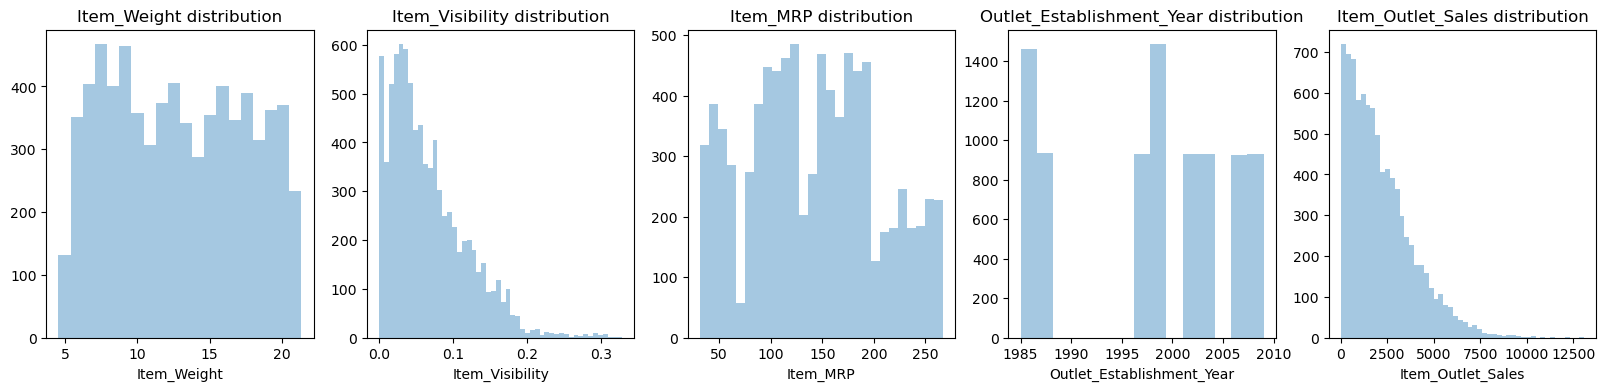

In [16]:
_, ax = plt.subplots(nrows=1, ncols=5, figsize=(20,4))

for index, col in enumerate(numeric_cols):
    sns.distplot(train[col], kde=False, ax=ax[index])
    ax[index].set_title(f'{col} distribution')

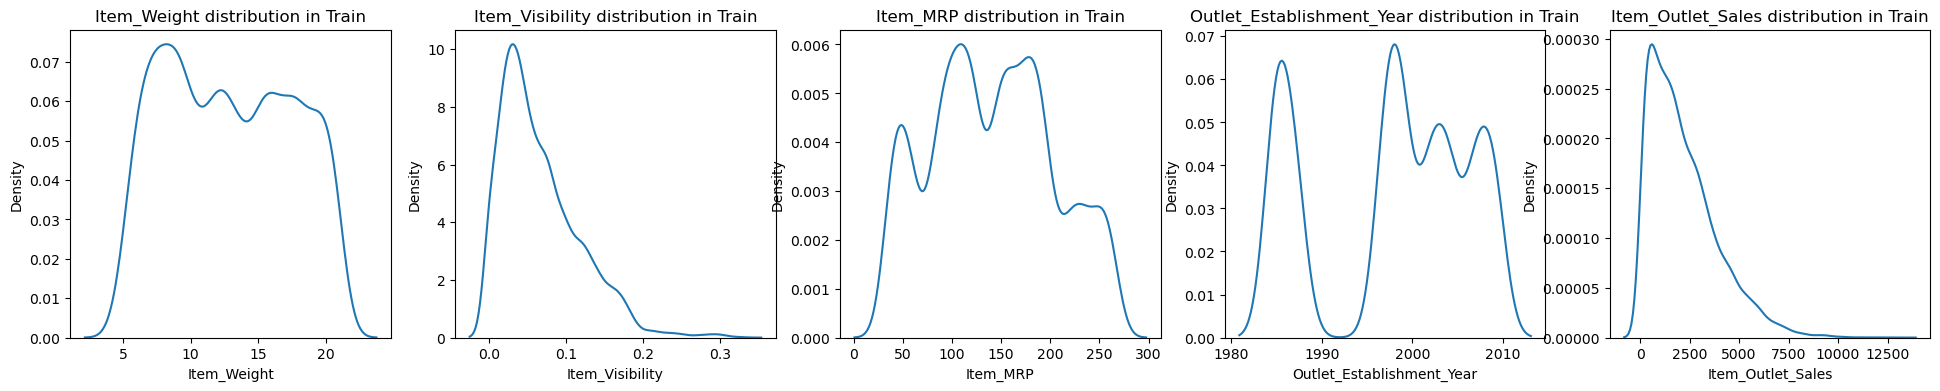

In [17]:
_, ax = plt.subplots(nrows=1, ncols=5, figsize=(24,4))

for index, col in enumerate(numeric_cols):
    sns.kdeplot(data=train, x=col, ax=ax[index])
    ax[index].set_title(f'{col} distribution in Train')

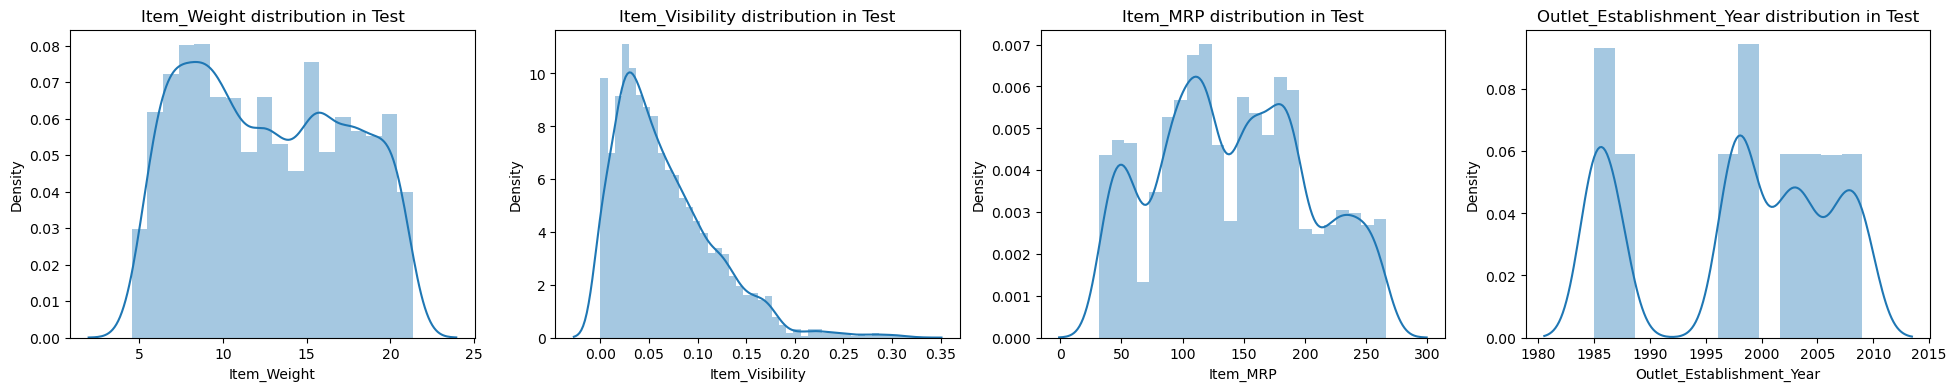

In [18]:
_, ax = plt.subplots(nrows=1, ncols=4, figsize=(24, 4))

for index, col in enumerate(['Item_Weight', 'Item_Visibility', 'Item_MRP', 'Outlet_Establishment_Year']):
    sns.distplot(test[col], kde=True, ax=ax[index])
    ax[index].set_title(f'{col} distribution in Test')

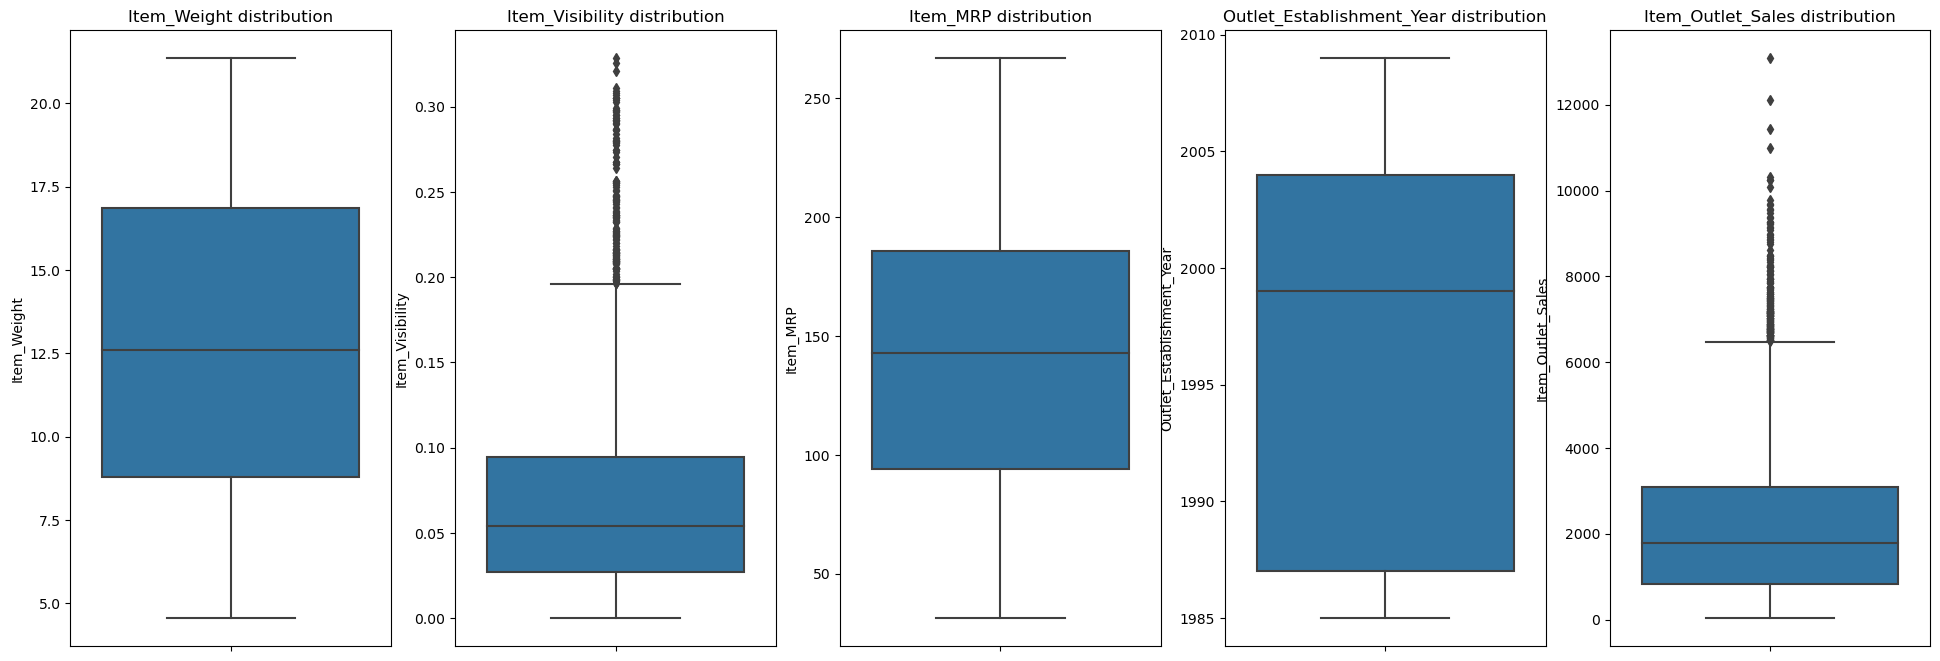

In [19]:
_, ax = plt.subplots(nrows=1, ncols=5, figsize=(24,8))
for index, col in enumerate(numeric_cols):
    sns.boxplot(data=train, y=col, ax=ax[index])
    ax[index].set_title(f'{col} distribution')

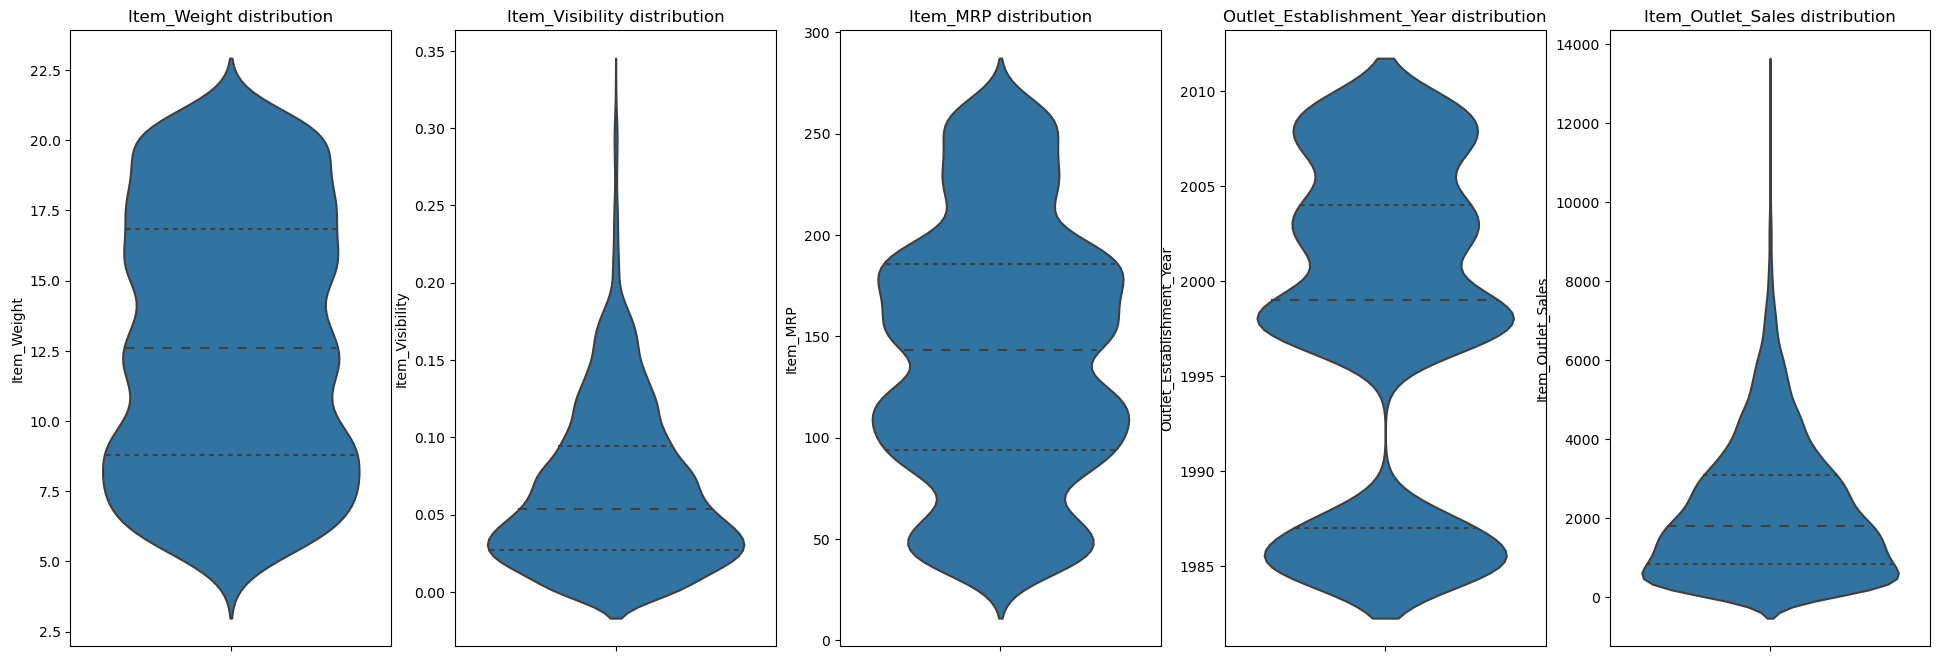

In [20]:
_, ax = plt.subplots(nrows=1, ncols=5, figsize=(24,8))
for index, col in enumerate(numeric_cols):
    sns.violinplot(data=train, y=col, ax=ax[index], inner='quartile')
    ax[index].set_title(f'{col} distribution')

In [21]:
# checknig object data type columns
categorical_cols = train.select_dtypes(include=['object']).columns.tolist()
categorical_cols

['Item_Identifier',
 'Item_Fat_Content',
 'Item_Type',
 'Outlet_Identifier',
 'Outlet_Size',
 'Outlet_Location_Type',
 'Outlet_Type']

In [22]:
categorical_cols_to_display = [ 
    'Item_Fat_Content',
    'Item_Type',
    'Outlet_Size',
    'Outlet_Location_Type',
    'Outlet_Type'
]

for col in categorical_cols_to_display:
    print(f'Number of values in the {col} column is:\n{train[col].value_counts()}')
    print('--' * 30)

Number of values in the Item_Fat_Content column is:
Item_Fat_Content
Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: count, dtype: int64
------------------------------------------------------------
Number of values in the Item_Type column is:
Item_Type
Fruits and Vegetables    1232
Snack Foods              1200
Household                 910
Frozen Foods              856
Dairy                     682
Canned                    649
Baking Goods              648
Health and Hygiene        520
Soft Drinks               445
Meat                      425
Breads                    251
Hard Drinks               214
Others                    169
Starchy Foods             148
Breakfast                 110
Seafood                    64
Name: count, dtype: int64
------------------------------------------------------------
Number of values in the Outlet_Size column is:
Outlet_Size
Medium    2793
Small     2388
High       932
Name: count, dtype: int64
------------

In [23]:
train['Outlet_Location_Type'].unique().tolist()

['Tier 1', 'Tier 3', 'Tier 2']

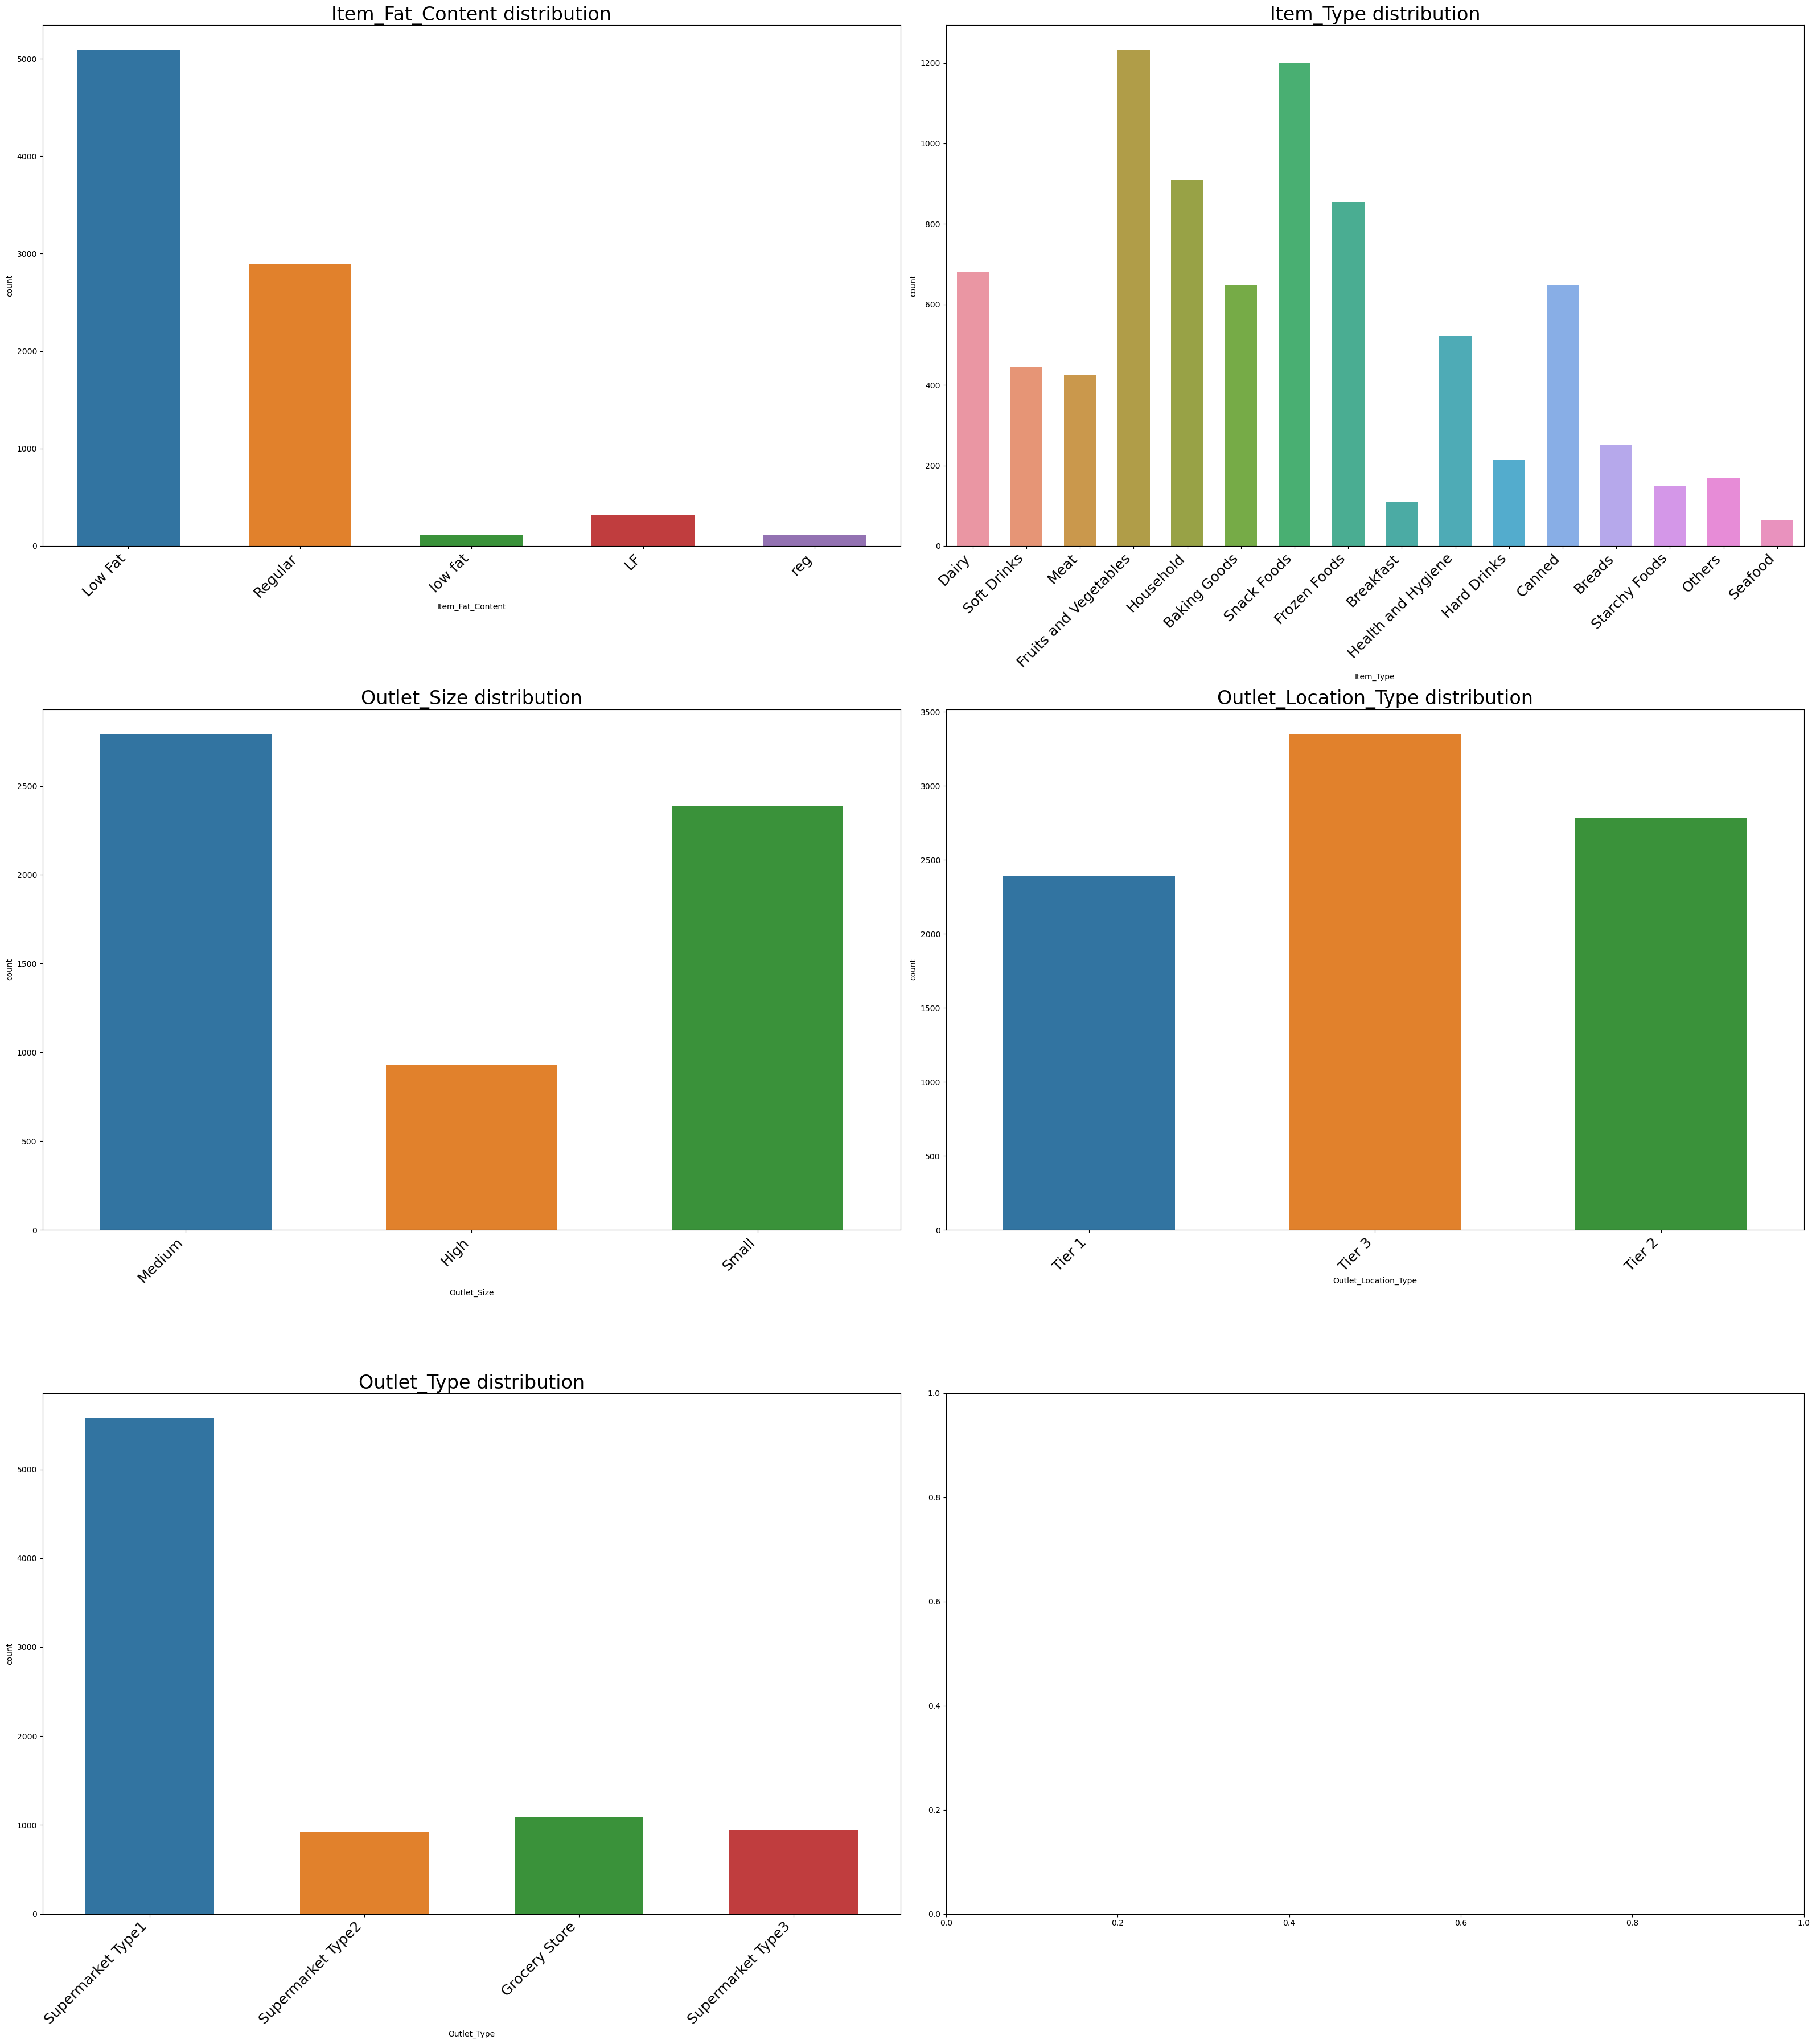

In [24]:
_, ax = plt.subplots(nrows=3, ncols=2, figsize=(32, 36))

for index, col in enumerate(categorical_cols_to_display):
    r = index // 2
    c = index % 2
    g = sns.countplot(data=train, x=col , ax=ax[r][c], width=0.6)
    g.set_xticklabels(g.get_xticklabels(), rotation=45, ha="right", fontsize=18)
    ax[r][c].set_title(f'{col} distribution', fontsize=24)
    plt.tight_layout()

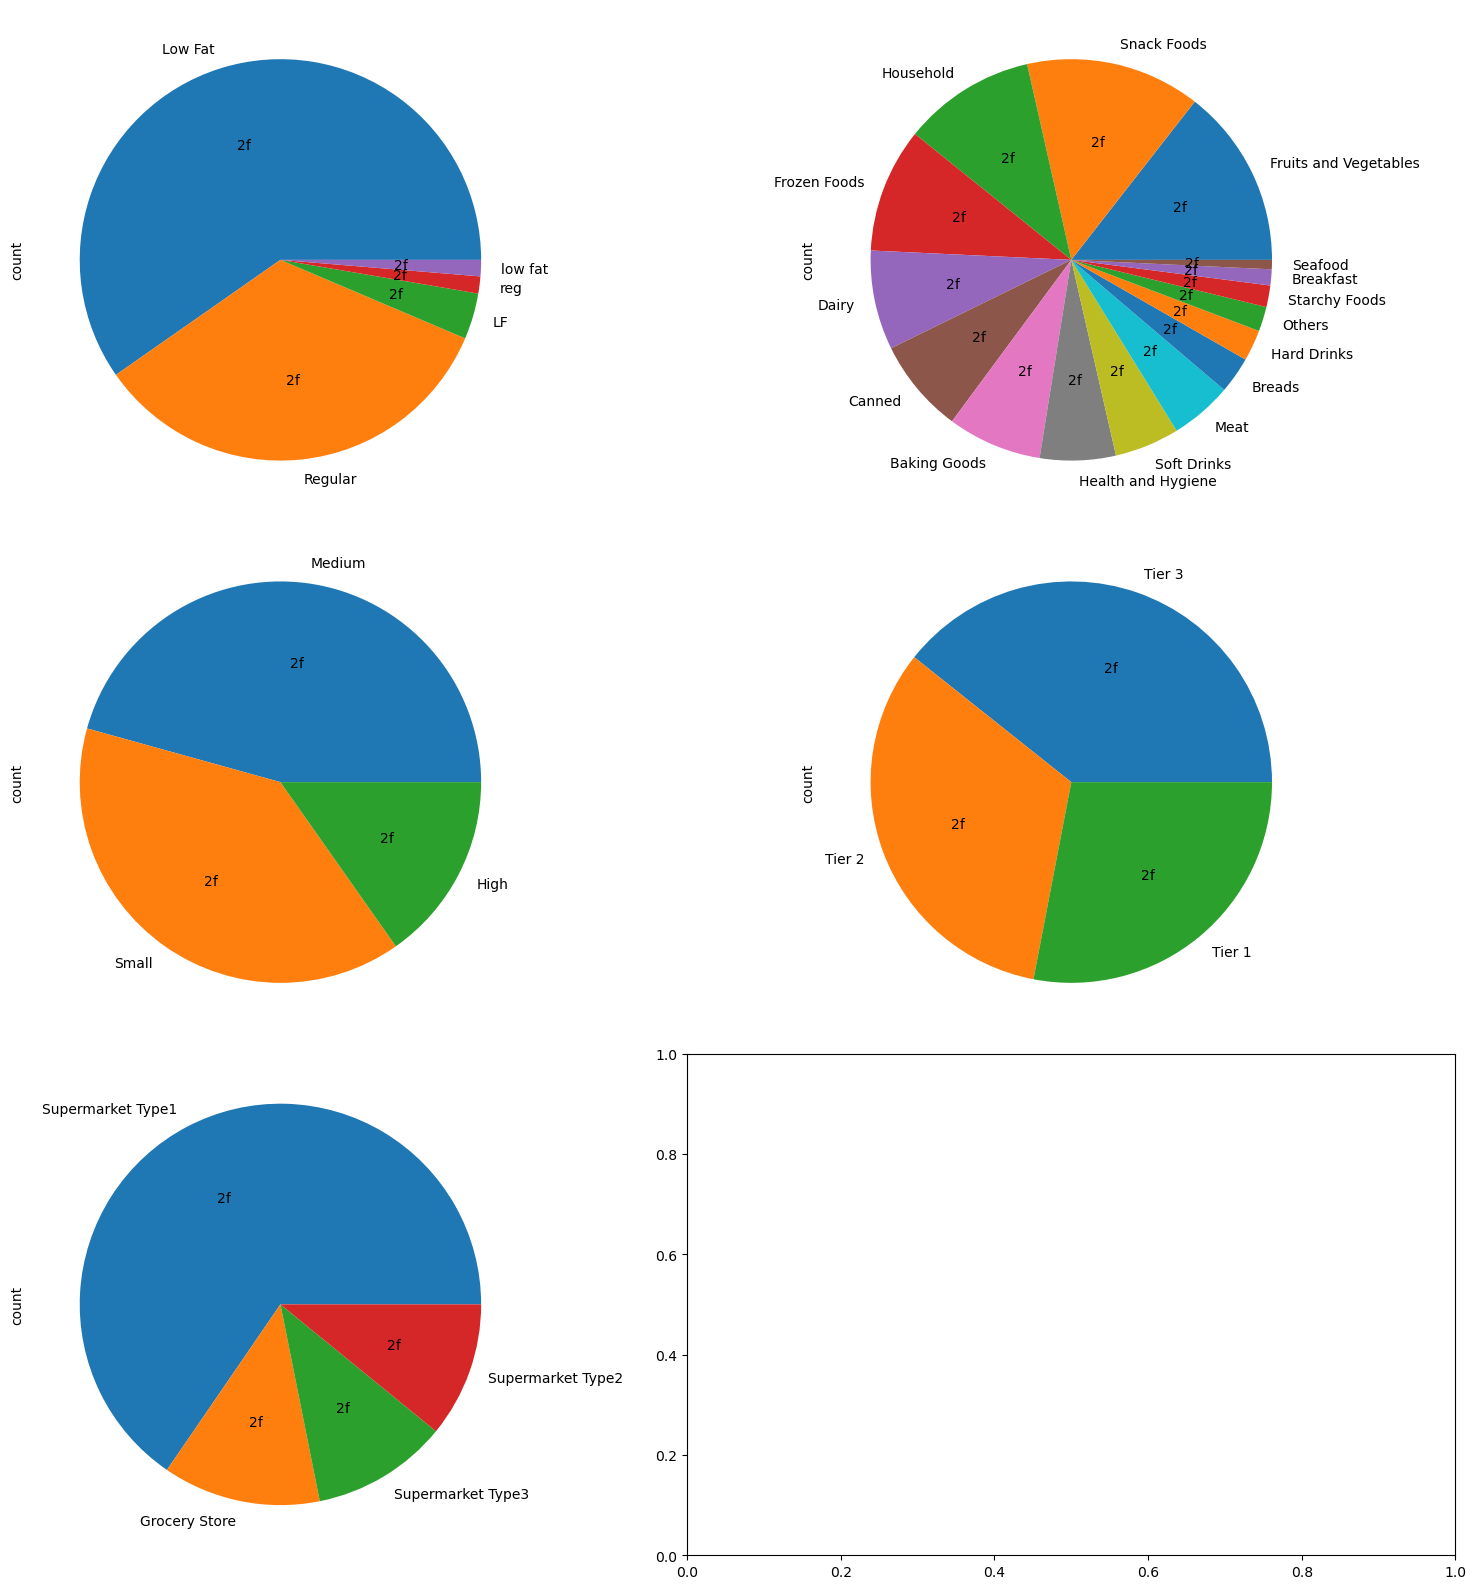

In [25]:
_, ax = plt.subplots(nrows=3, ncols=2, figsize=(16,16))
for index, col in enumerate(categorical_cols_to_display):
    r = index // 2
    c = index % 2
    train[col].value_counts().plot(kind='pie', autopct="2f", ax=ax[r][c])
    plt.tight_layout()

In [26]:
target = 'Item_Outlet_Sales'

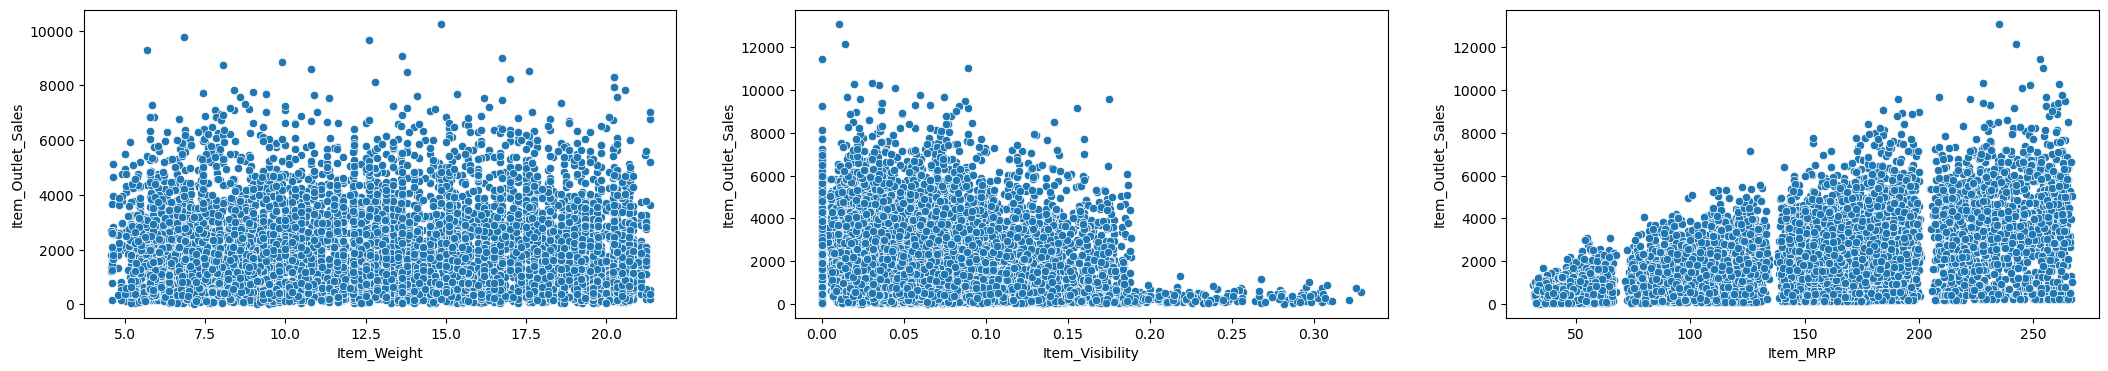

In [27]:
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(26, 4))

for index, col in enumerate(['Item_Weight', 'Item_Visibility', 'Item_MRP']):
    sns.scatterplot(data=train,x=col, y=target, ax=ax[index])

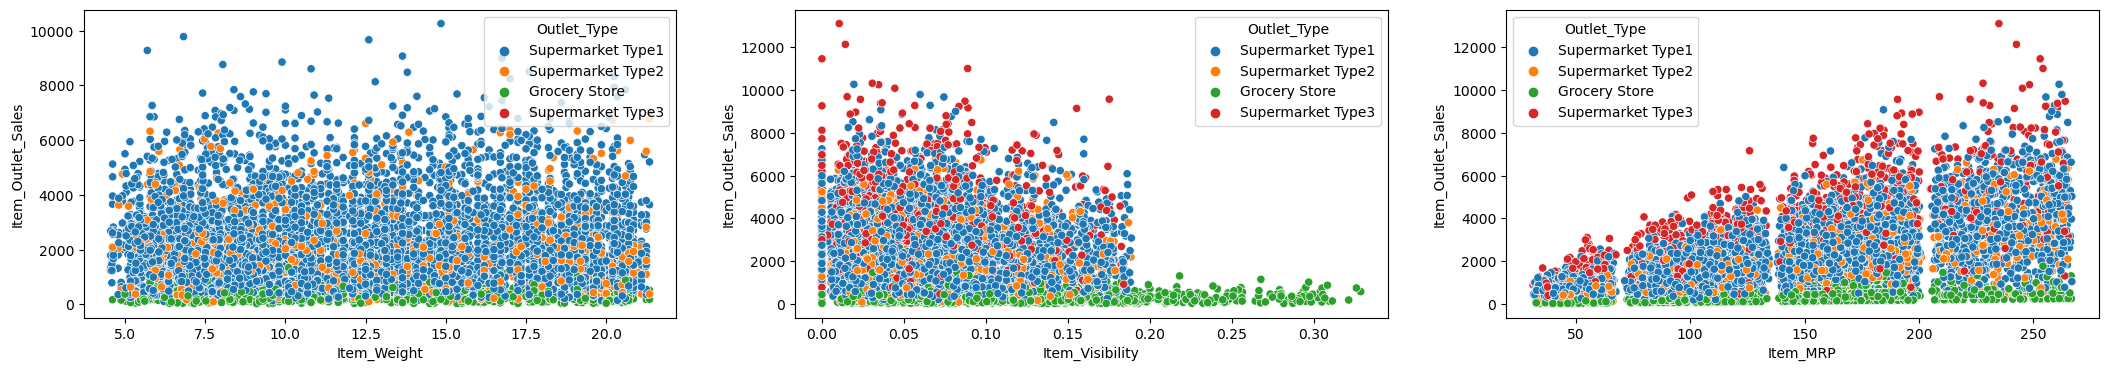

In [28]:
_, ax = plt.subplots(nrows=1, ncols=3, figsize=(26,4))

for index, col in enumerate(['Item_Weight','Item_Visibility','Item_MRP']):
    sns.scatterplot(data=train, x=col, y=target, ax=ax[index], hue='Outlet_Type')

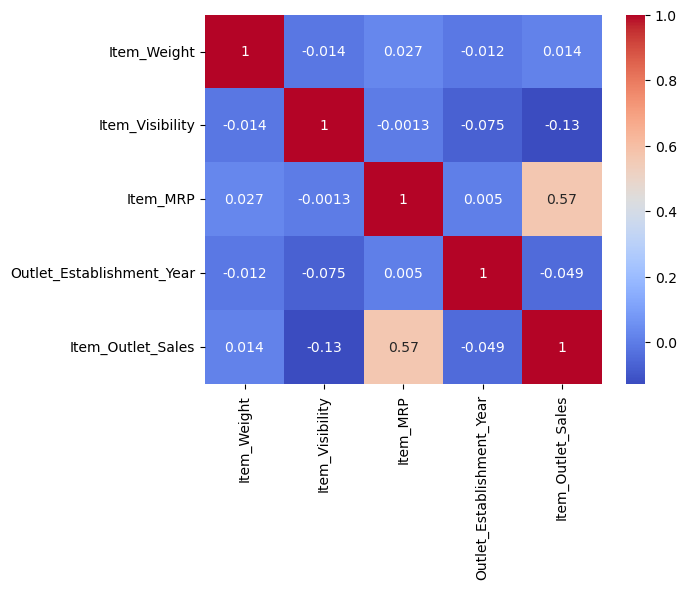

In [29]:
numeric = train.select_dtypes(include=['float64', 'int64'])
corr_matrix = numeric.corr()

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
plt.show()

<Axes: xlabel='Outlet_Size', ylabel='Item_Outlet_Sales'>

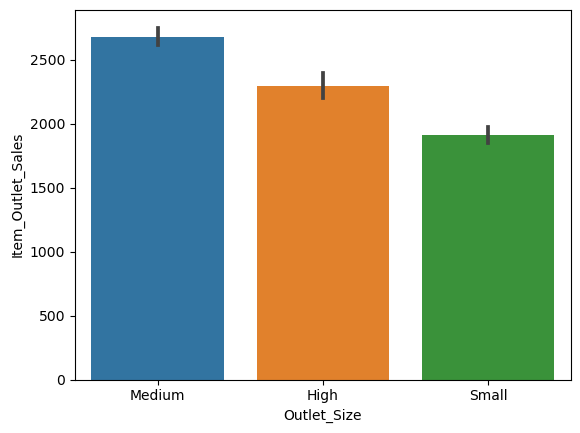

In [30]:
sns.barplot(data=train, x='Outlet_Size', y=target)

In [31]:
train.Outlet_Establishment_Year

0       1999
1       2009
2       1999
3       1998
4       1987
        ... 
8518    1987
8519    2002
8520    2004
8521    2009
8522    1997
Name: Outlet_Establishment_Year, Length: 8523, dtype: int64

In [32]:
# filling the object values with mode and float types with mean

# for train
train['Outlet_Size'] = train.Outlet_Size.fillna(train.Outlet_Size.dropna().mode()[0])
train['Item_Weight'] = train.Item_Weight.fillna(train.Item_Weight.mean())

# for test
test['Outlet_Size'] = test.Outlet_Size.fillna(test.Outlet_Size.dropna().mode()[0])
test['Item_Weight'] = test.Item_Weight.fillna(test.Item_Weight.mean())

In [33]:
# checking null values sum
train.isnull().sum()

Item_Identifier              0
Item_Weight                  0
Item_Fat_Content             0
Item_Visibility              0
Item_Type                    0
Item_MRP                     0
Outlet_Identifier            0
Outlet_Establishment_Year    0
Outlet_Size                  0
Outlet_Location_Type         0
Outlet_Type                  0
Item_Outlet_Sales            0
dtype: int64

## Feature Engineering

Upper limit:  0.195979015
Lower limit:  -0.07440424500000001


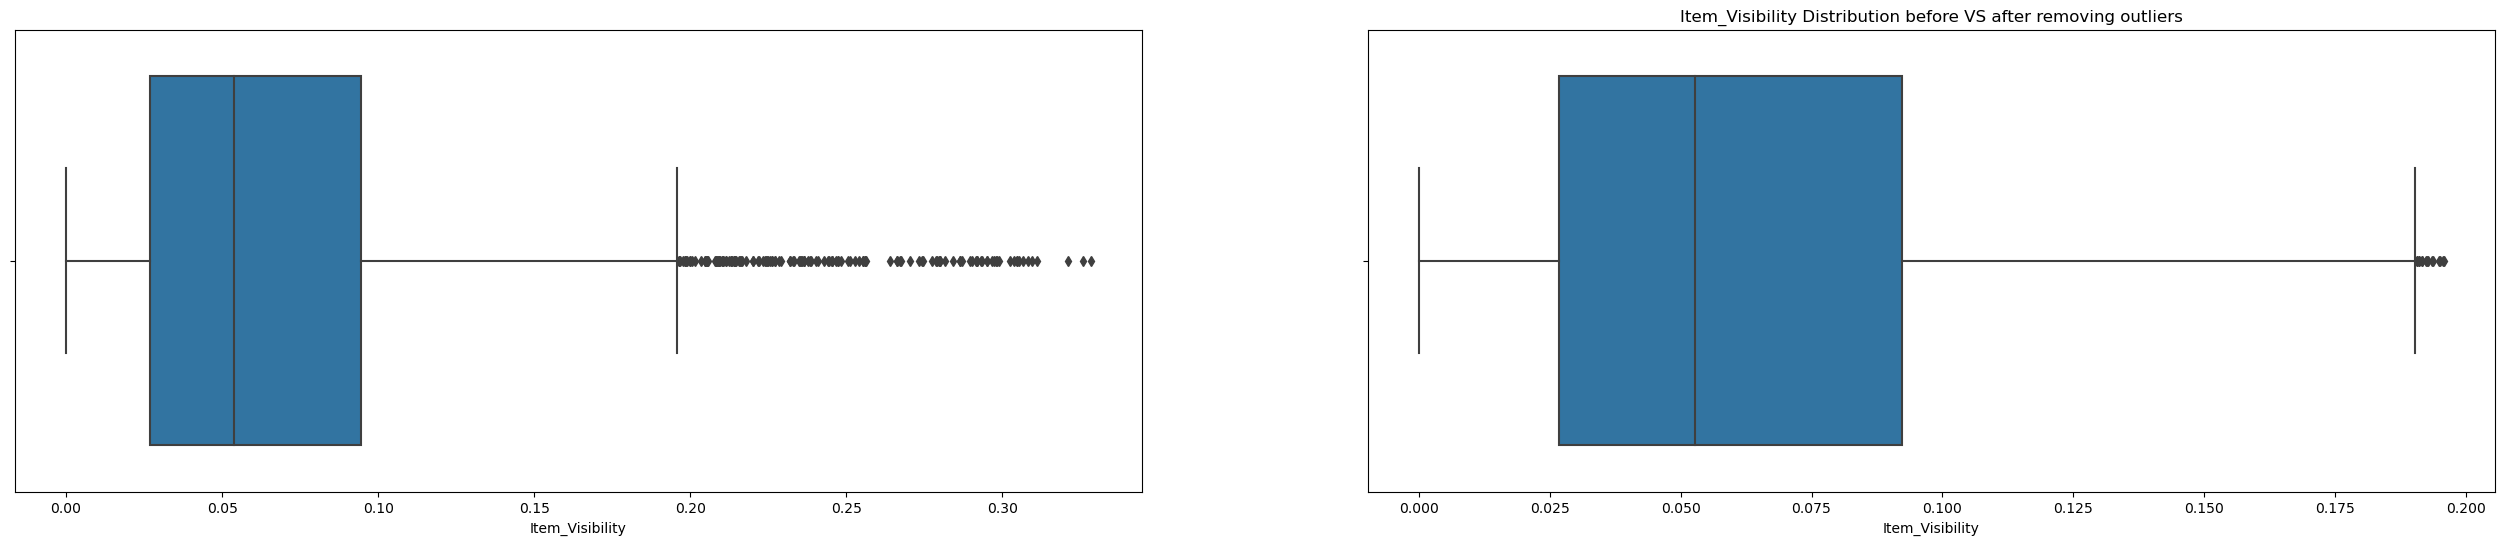

In [34]:
def detect_outliers(df, feature):
    Q1  = df[feature].quantile(0.25)
    Q3  = df[feature].quantile(0.75)
    IQR = Q3 - Q1
    upper_limit = Q3 + 1.5 * IQR
    lower_limit = Q1 - 1.5 * IQR
    return upper_limit, lower_limit

upper, lower = detect_outliers(train, "Item_Visibility")
print("Upper limit: ", upper)
print("Lower limit: ", lower)

_, ax = plt.subplots(nrows=1, ncols=2, figsize=(32, 6))
sns.boxplot(x=train['Item_Visibility'], ax=ax[0])

# removing outliers using the above function
train = train[(train['Item_Visibility'] > lower) & (train['Item_Visibility'] < upper)] #train
test = test[(test['Item_Visibility'] > lower) & (test['Item_Visibility'] < upper)]     #test

sns.boxplot(x=train['Item_Visibility'], ax=ax[1])
plt.title('Item_Visibility Distribution before VS after removing outliers')
plt.show()

Upper limit:  6499.2067
Lower limit:  -2499.7460999999994


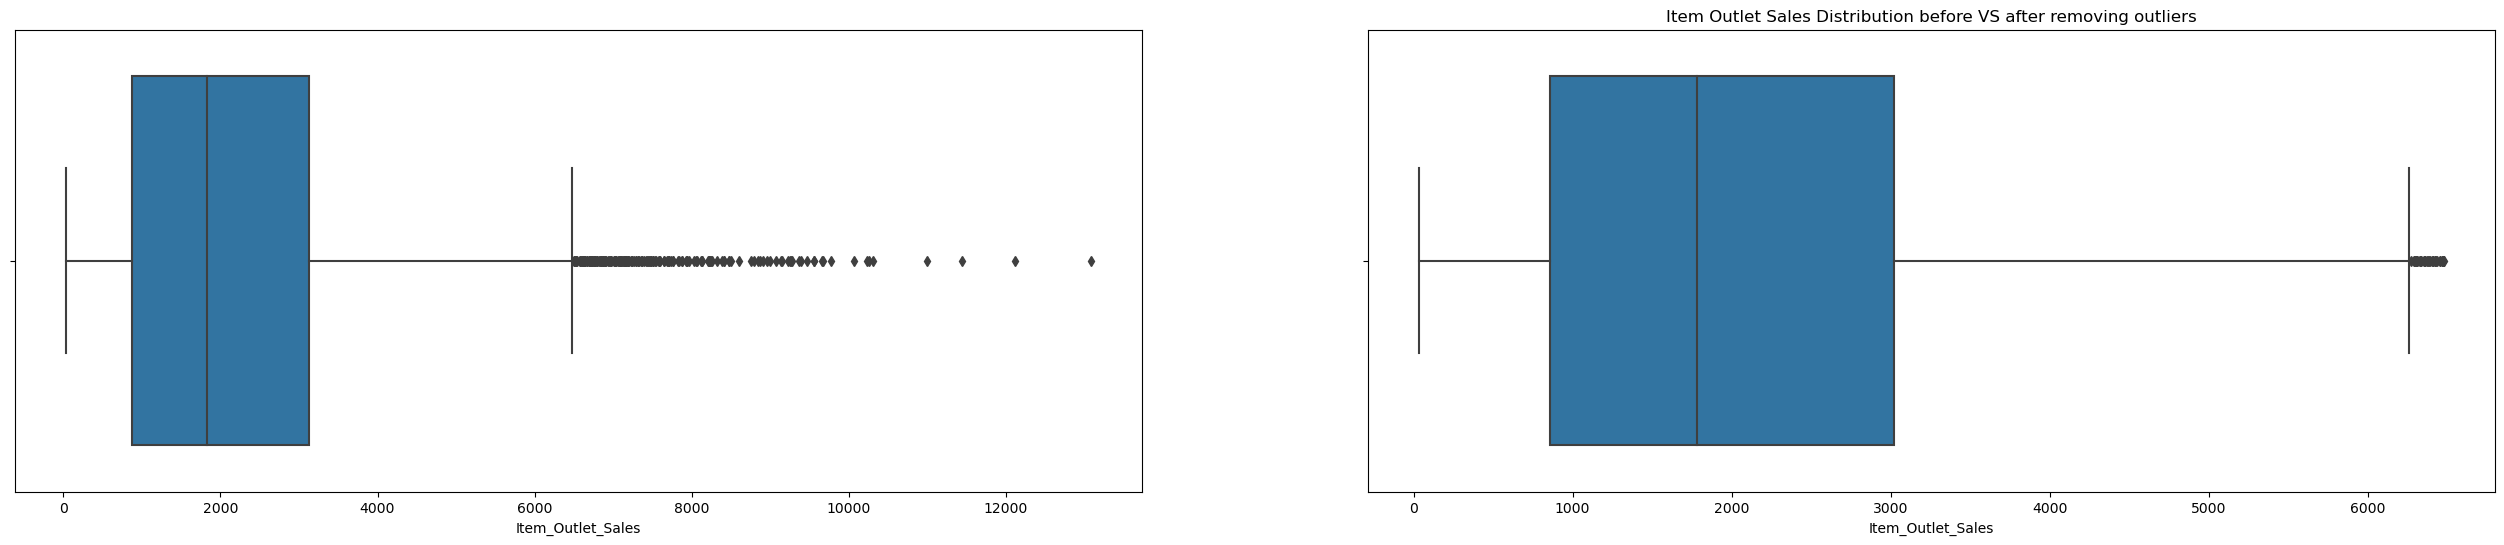

In [36]:
# detect outliers in the Item_Outlet_Sales feature
upper, lower = detect_outliers(train, "Item_Outlet_Sales")
print("Upper limit: ", upper)
print("Lower limit: ", lower)

_, ax = plt.subplots(nrows=1, ncols=2, figsize=(32, 6))
sns.boxplot(x=train['Item_Outlet_Sales'], ax=ax[0])

train = train[(train['Item_Outlet_Sales'] > lower) & (train['Item_Outlet_Sales'] < upper)]

sns.boxplot(x=train['Item_Outlet_Sales'], ax=ax[1])
plt.title('Item Outlet Sales Distribution before VS after removing outliers')
plt.show()

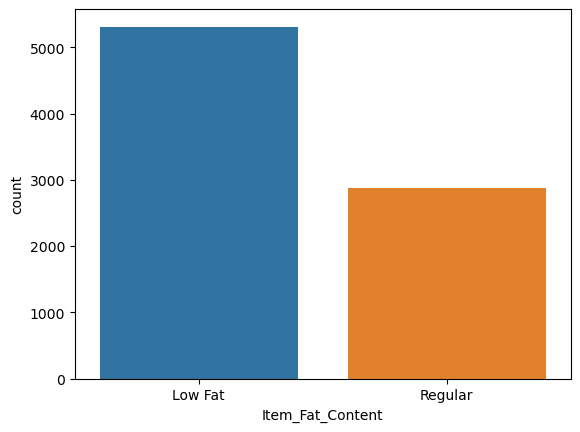

In [37]:
# errors in the Item_Fat_Content
train['Item_Fat_Content'] = train['Item_Fat_Content'].map({'Low Fat': 'Low Fat',
                                                           'low fat': 'Low Fat',
                                                           'LF': 'Low Fat',
                                                           'Regular': 'Regular',
                                                           'reg': 'Regular'})
test['Item_Fat_Content'] = test['Item_Fat_Content'].map({'Low Fat': 'Low Fat',
                                                        'low fat': 'Low Fat',
                                                        'LF': 'Low Fat',
                                                        'Regular': 'Regular',
                                                        'reg': 'Regular'})
sns.countplot(x=train['Item_Fat_Content']);

<Axes: xlabel='Outlet_Age', ylabel='count'>

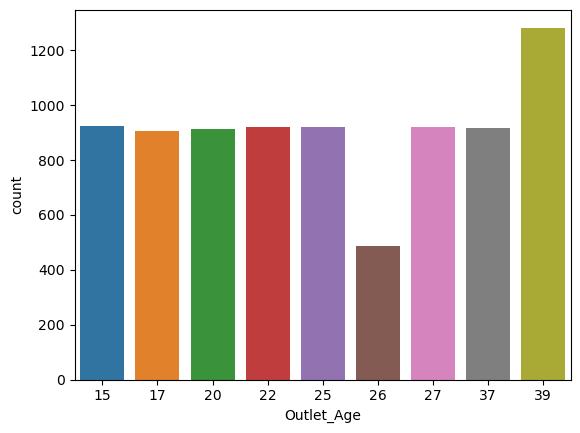

In [38]:
# amount of established years in new column and delete old column
train['Outlet_Age'] = 2024 - train['Outlet_Establishment_Year']
test['Outlet_Age'] = 2024 - test['Outlet_Establishment_Year']

del train['Outlet_Establishment_Year']
del test['Outlet_Establishment_Year']

sns.countplot(x=train['Outlet_Age'])

## Encoding Categorical Variable

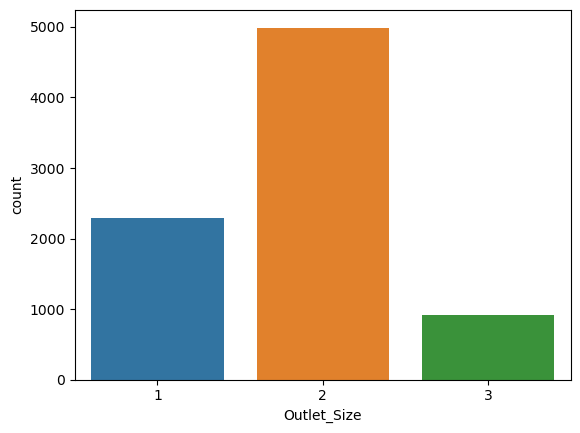

In [39]:
# Lable Encoding

train['Outlet_Size'] = train['Outlet_Size'].map({'Small':1,
                                                'Medium':2,
                                                'High':3}).astype(int)
test['Outlet_Size'] = test['Outlet_Size'].map({'Small':1,
                                              'Medium':2,
                                              'High':3}).astype(int)
sns.countplot(x=train['Outlet_Size']);

<Axes: xlabel='Outlet_Location_Type', ylabel='count'>

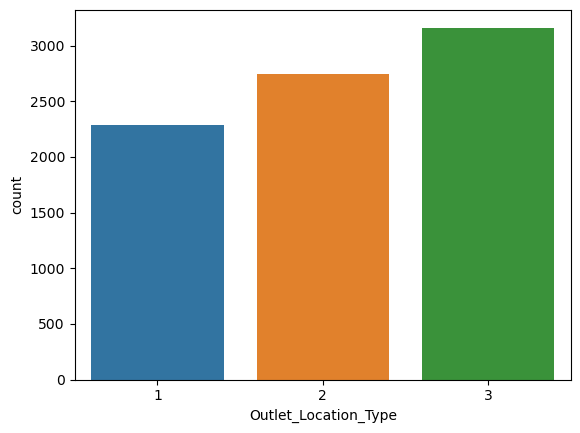

In [40]:
# Outlet_Location_Type feature encoding by getting the last character and conveting to int type

train['Outlet_Location_Type'] = train['Outlet_Location_Type'].str[-1:].astype(int)
test['Outlet_Location_Type'] = test['Outlet_Location_Type'].str[-1:].astype(int)
sns.countplot(x=train['Outlet_Location_Type'])

<Axes: xlabel='Item_Identifier_Categories', ylabel='count'>

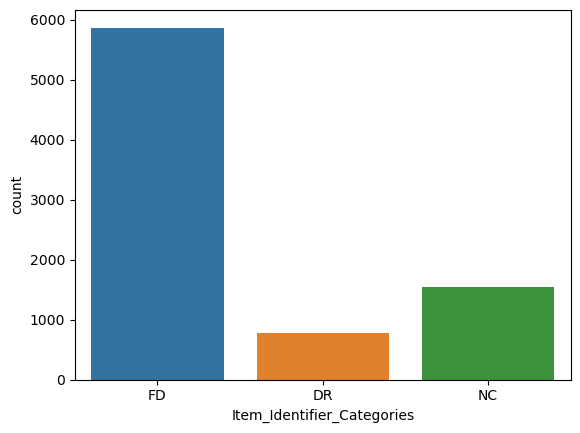

In [41]:
train['Item_Identifier_Categories'] = train['Item_Identifier'].str[0:2]
test['Item_Identifier_Categories'] = test['Item_Identifier'].str[0:2]

sns.countplot(x=train['Item_Identifier_Categories'])

In [42]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age,Item_Identifier_Categories
0,FDA15,9.30,Low Fat,0.016047,Dairy,249.8092,OUT049,2,1,Supermarket Type1,3735.1380,25,FD
1,DRC01,5.92,Regular,0.019278,Soft Drinks,48.2692,OUT018,2,3,Supermarket Type2,443.4228,15,DR
2,FDN15,17.50,Low Fat,0.016760,Meat,141.6180,OUT049,2,1,Supermarket Type1,2097.2700,25,FD
3,FDX07,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,OUT010,2,3,Grocery Store,732.3800,26,FD
4,NCD19,8.93,Low Fat,0.000000,Household,53.8614,OUT013,3,3,Supermarket Type1,994.7052,37,NC


In [43]:
# Label Encoder for Ordinate Data

encoder = LabelEncoder()
ordinal_features = ['Item_Fat_Content', 'Outlet_Type', 'Outlet_Location_Type']

for feature in ordinal_features:
    train[feature] = encoder.fit_transform(train[feature])
    test[feature]  = encoder.fit_transform(test[feature])
    
train.shape

(8193, 13)

In [44]:
test.shape

(5570, 12)

In [45]:
train.head()

,Item_Identifier,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Identifier,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales,Outlet_Age,Item_Identifier_Categories
0,FDA15,9.30,0,0.016047,Dairy,249.8092,OUT049,2,0,1,3735.1380,25,FD
1,DRC01,5.92,1,0.019278,Soft Drinks,48.2692,OUT018,2,2,2,443.4228,15,DR
2,FDN15,17.50,0,0.016760,Meat,141.6180,OUT049,2,0,1,2097.2700,25,FD
3,FDX07,19.20,1,0.000000,Fruits and Vegetables,182.0950,OUT010,2,2,0,732.3800,26,FD
4,NCD19,8.93,0,0.000000,Household,53.8614,OUT013,3,2,1,994.7052,37,NC


## One Hot Encoding

In [46]:
# One hot Encoding for 'Item_Type' variable

train = pd.get_dummies(train, columns=['Item_Type', 'Item_Identifier_Categories','Outlet_Identifier'], drop_first=True)
test = pd.get_dummies(test, columns=['Item_Type','Item_Identifier_Categories','Outlet_Identifier'],drop_first=True)

In [47]:
train.head()
train.shape

(8193, 36)

## Preprocessing Data

In [48]:
# let's drop useless column
train.drop(labels=['Item_Identifier'],axis=1, inplace=True)
test.drop(labels=['Item_Identifier'],axis=1, inplace=True)

In [49]:
X = train.drop('Item_Outlet_Sales', axis=1)
y = train['Item_Outlet_Sales']

In [50]:
X.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_MRP,Outlet_Size,Outlet_Location_Type,Outlet_Type,Outlet_Age,Item_Type_Breads,Item_Type_Breakfast,...,Item_Identifier_Categories_NC,Outlet_Identifier_OUT013,Outlet_Identifier_OUT017,Outlet_Identifier_OUT018,Outlet_Identifier_OUT019,Outlet_Identifier_OUT027,Outlet_Identifier_OUT035,Outlet_Identifier_OUT045,Outlet_Identifier_OUT046,Outlet_Identifier_OUT049
0,9.30,0,0.016047,249.8092,2,0,1,25,False,False,...,False,False,False,False,False,False,False,False,False,True
1,5.92,1,0.019278,48.2692,2,2,2,15,False,False,...,False,False,False,True,False,False,False,False,False,False
2,17.50,0,0.016760,141.6180,2,0,1,25,False,False,...,False,False,False,False,False,False,False,False,False,True
3,19.20,1,0.000000,182.0950,2,2,0,26,False,False,...,False,False,False,False,False,False,False,False,False,False
4,8.93,0,0.000000,53.8614,3,2,1,37,False,False,...,True,True,False,False,False,False,False,False,False,False


In [51]:
y.head()

0    3735.1380
1     443.4228
2    2097.2700
3     732.3800
4     994.7052
Name: Item_Outlet_Sales, dtype: float64

In [52]:
# splitting into training set and test set 80%-20%
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2)

In [53]:
lin_reg_model = LinearRegression()
lin_reg_model.fit(X_train, y_train)

LinearRegression()

In [54]:
# Prediction
lin_reg_predictions = lin_reg_model.predict(X_test)

In [55]:
print('Training score: {}'.format(lin_reg_model.score(X_train,y_train)))
print('Test score:     {}'.format(lin_reg_model.score(X_test,y_test)))

Training score: 0.5516657749034781
Test score:     0.5471728591811289


In [56]:
# Evaluation
lin_reg_mse = mean_squared_error(y_test, lin_reg_predictions)
lin_reg_rmse = math.sqrt(lin_reg_mse)
lin_reg_r2 = r2_score(y_test, lin_reg_predictions)

print('RMSE \t  --> {}'.format(lin_reg_rmse))
print('R2 Score --> {}'.format(lin_reg_r2))

RMSE 	  --> 1021.5214420862883
R2 Score --> 0.5471728591811289


In [58]:
steps = [
    ('scale', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('model', LinearRegression())
]

lin_reg_pipeline = Pipeline(steps)

lin_reg_pipeline.fit(X_train, y_train)

print('Training score : {}'.format(lin_reg_pipeline.score(X_train, y_train)))
print('Test score: {}'.format(lin_reg_pipeline.score(X_test,y_test)))

Training score : 0.5998225706441689
Test score: 0.5662355632803241


In [61]:
steps = [
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('model', Ridge(alpha=7, fit_intercept=True))
]

ridge_pipeline = Pipeline(steps)
ridge_pipeline.fit(X_train, y_train)

print('Training Score  : {}'.format(ridge_pipeline.score(X_train, y_train)))
print('Test Score      : {}'.format(ridge_pipeline.score(X_test, y_test)))

Training Score  : 0.5998213122987628
Test Score      : 0.5662904189776015


In [62]:
# Predictions for Ridge
ridge_predictions = ridge_pipeline.predict(X_test)

In [63]:
# Evaluation
ridge_mse = mean_squared_error(y_test, ridge_predictions)
ridge_rmse = math.sqrt(ridge_mse)
ridge_r2 = r2_score(y_test, ridge_predictions)

print('Ridge RMSE  \t     ---> {}'.format(ridge_rmse))
print('Ridge R2 Score     ---> {}'.format(ridge_r2))

Ridge RMSE  	     ---> 999.7255019674703
Ridge R2 Score     ---> 0.5662904189776015


In [64]:
# Lasso

steps = [
    ('scaler', StandardScaler()),
    ('poly', PolynomialFeatures(degree=2)),
    ('model', Lasso(alpha=0.2, fit_intercept=True))
]

lasso_pipeline = Pipeline(steps)

lasso_pipeline.fit(X_train, y_train)

print('Training score  : {}'    .format(lasso_pipeline.score(X_train, y_train)))
print('Test score      : {}'    .format(lasso_pipeline.score(X_test, y_test)))

Training score  : 0.5997864842164852
Test score      : 0.566810150811661


In [65]:
# Predictions for Lasso
lasso_predictions = lasso_pipeline.predict(X_test)

In [66]:
# Evaluation
lasso_mse  = mean_squared_error(y_test , lasso_predictions)
lasso_rmse = math.sqrt(lasso_mse)
lasso_r2   = r2_score(y_test, lasso_predictions)

print('Lasso RMSE  \t         ----> {}'.format(lasso_rmse))
print('Lasso R2 Score         ----> {}'.format(lasso_r2))

Lasso RMSE  	         ----> 999.1263165378849
Lasso R2 Score         ----> 0.566810150811661


In [68]:
# Random Forest
from sklearn.ensemble import RandomForestRegressor 

rand_forest_model = RandomForestRegressor()
rand_forest_model.fit(X_train, y_train)

RandomForestRegressor()

In [70]:
# Predictions for RandomForestRegressor
rand_forest_predictions = rand_forest_model.predict(X_test)

In [71]:
print('Training score  : {}'.format(rand_forest_model.score(X_train, y_train)))
print('Test score      : {}'.format(rand_forest_model.score(X_test, y_test)))

Training score  : 0.9347666660356954
Test score      : 0.520517954771466


In [72]:
# Evaluation
rand_forest_mse = mean_squared_error(y_test , rand_forest_predictions)
rand_forest_rmse = math.sqrt(rand_forest_mse)
rand_forest_r2 = r2_score(y_test, rand_forest_predictions)

print('RandomForest RMSE  \t     --> {}'.format(rand_forest_rmse))
print('RandomForest R2 Score     --> {}'.format(rand_forest_r2))

RandomForest RMSE  	     --> 1051.1566378236232
RandomForest R2 Score     --> 0.520517954771466


In [73]:
# XGBoost

xgb_model = XGBRegressor()
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [74]:
# Predictions for XGBoost
xgb_predictions = xgb_model.predict(X_test)

In [75]:
print('XGBoost Training score  : {}'.format(xgb_model.score(X_train, y_train)))
print('XGBoost Test score      : {}'.format(xgb_model.score(X_test, y_test)))

XGBoost Training score  : 0.855475128396549
XGBoost Test score      : 0.4740711163368567


In [76]:
# Evaluation
xgb_mse = mean_squared_error(y_test , xgb_predictions)
xgb_rmse = math.sqrt(xgb_mse)
xgb_r2 = r2_score(y_test, xgb_predictions)

print('XGBoost RMSE  \t   ----> {}'.format(xgb_rmse))
print('XGBoost R2 Score   ----> {}'.format(xgb_r2))

XGBoost RMSE  	   ----> 1100.892147232883
XGBoost R2 Score   ----> 0.4740711163368567
